# Torus links and neural networks

We propose to investigate how complex a neural network needs to be in order to accurately distinguish the components of increasingly tangled links in ambient three-dimensional space. More precisely, we use simulated data to measure the size and number of layers a neural network needs to have to accurately separate the components of torus links. If a quick exposition about torus knots and links is needed, the wikipedia page wikipedia.org/wiki/Torus_knot provides a fast account. Key facts are: 
- a torus link is a link in Euclidean $3$-space that lies on the surface of the standardly embedded torus,
- the $(p, q)$-torus link has $n = gcd(p, q)$ component, each of which is a $(p', q')$-torus knot where $p' = p/n$, $q' = q/n$, 
- the $(p, q)$-torus knot for coprime $p, q$ winds around the torus $p$ times in the longitude direction and $q$ times around the meridian direction. 

At each step of our experiment, we shall fix integers $p$ and $q$ with $gcd(p, q) = n$ and train neural networks to tell apart the $n$ strands of the $(p, q)$-torus link. As $p$ and $q$ increase, the torus link of type $(p, q)$ becomes increasingly tangled, in the sense that its crossing number, linking number and many other invariants increase. The cases where $n = gcd(p, q) = 2$ are of prime interest, since it is possible to get very complicated situation with two strands only. 

## Generating the simulated data

We begin with Python functions generating points that lie on the two strands of a $(p, q)$-torus link, $gcd(p, q) = n$. Thankfully, there are easy parameterizations for these manifolds. (This actually motivated the choice of torus links over other infinite families. In general, finding parameterizations or algebraic equations for a link is a notoriously hard problem.) If $p$ and $q$ are coprime, the one and only strand of the $(p, q)$-torus knot is parameterized by
$$
x(t) = (\cos(qt) + 2)\cos(pt), 
$$
$$
y(t) = (\cos(qt) + 2)\sin(pt), 
$$
$$
z(t) = -\sin(qt),
$$
where $t \in [0, 2\pi]$. When $n = gcd(p, q)$ is greater than one, we can use the parameterization above with $p' = p/n$ and $q' = q/n$ to get one component of the $(p, q)$-torus link. We then rely on the following fact: the other components are obtained by applying rotations of angles $2\pi k/qn$, $0 < k < n$ along the $z$-axis to the first component. The proof of this last assertion follows from further properties of torus knots and links. It can be derived from, e.g, the connection between torus links and the algebraic equations $w_1^p + w_2^q = 0$ in $\mathbb{C}^2$. From now on, we speak of the zeroth, first, ..., $(n-1)$-st component of a link, instead of the first, second, ... etc. to match Python's enumerating conventions. 

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
#This last line requires the jupyter-matplotlib extension. pip install ipympl

In [212]:
def x(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.cos(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def y(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.sin(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def z(q, t):
    return -np.sin(q*t)

def torusLink(p, q, t, phase_shift):
    return [x(p, q, t, phase_shift), y(p, q, t, phase_shift), z(q, t)]

In [213]:
#Implements the generating strategy outlined above. 
def simulateData(p, q, N): 
    n = np.gcd(p, q)
    p_prime = int(p/n)
    q_prime = int(q/n)
    features = [torusLink(p_prime, q_prime, t, 0) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]
    responses = np.zeros(int(N/n))
    for k in range(1, n):
        features = np.concatenate((features, [torusLink(p_prime, q_prime, t, 2*np.pi*k/(q_prime*n)) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]))
        responses = np.concatenate((responses, k*np.ones(int(N/n))))
    return [features, responses]

We are ready to generate data: we do so and plot it. 

In [232]:
p, q = 8, 6 
n = np.gcd(p, q)
N = 1000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
features = simulateData(p, q, N)[0]

In [233]:
#A function to plot at most ten colored collections of points in three dimensions
def threeDPlotRedBlue(collections):
    colors = matplotlib.cm.tab10(range(10)) #Provides a collection of ten colors
    ax = plt.figure().add_subplot(projection = '3d')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    for i in range(len(collections)): 
        ax.scatter(collections[i][0], collections[i][1], collections[i][2], color = colors[i])
    return ax

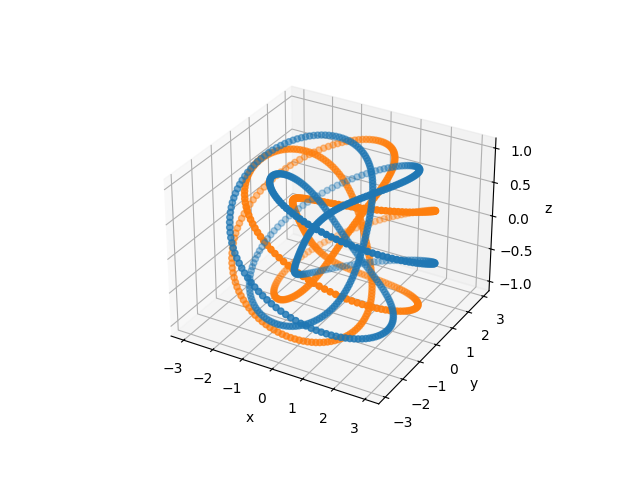

In [234]:
collections = []
for i in range(n): #We retrieve the points in feature component by component
    x_ = [features[k][0] for k in range(i*int(len(features)/n), (i+1)*int(len(features)/n))]
    y_ = [features[k][1] for k in range(i*int(len(features)/n), (i+1)*int(len(features)/n))]
    z_ = [features[k][2] for k in range(i*int(len(features)/n), (i+1)*int(len(features)/n))]
    collections.append([x_, y_, z_])

ax = threeDPlotRedBlue(collections)
plt.show()

In [227]:
plt.close() #Frees the memory occupied by the figure

## Training neural networks

In [235]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [ ]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger